
# 01 — Exploratory Analysis: El Paso Dataset


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Cargar datos ---
df = pd.read_csv("../data/Data_ElPaso_Clean.csv", parse_dates=[0], index_col=0)
df.index.name = "time"

(df.info())
(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 107172 entries, 2022-02-21 18:00:00+00:00 to 2024-03-06 23:50:00+00:00
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   CSI      107172 non-null  float64
 1   GHI      107172 non-null  float64
 2   Presion  107172 non-null  float64
 3   TempAmb  107172 non-null  float64
 4   Wind Y   107172 non-null  float64
 5   Wind X   107172 non-null  float64
 6   DoY Sin  107172 non-null  float64
 7   DoY Cos  107172 non-null  float64
 8   horas    107172 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 8.2 MB


,CSI,GHI,Presion,TempAmb,Wind Y,Wind X,DoY Sin,DoY Cos,horas
time,,,,,,,,,
2022-02-21 18:00:00+00:00,2.0,3.0352,1000.7912,29.9672,2.832954,-0.093612,0.778764,0.627317,18
2022-02-21 18:10:00+00:00,0.0,0.3562,1000.9321,29.5689,3.387552,0.796801,0.778764,0.627317,18
2022-02-21 18:20:00+00:00,0.0,0.0000,1001.1479,29.2593,2.091197,-0.878680,0.778764,0.627317,18
2022-02-21 18:30:00+00:00,0.0,0.0000,1001.2992,28.9183,-0.487957,-1.478562,0.778764,0.627317,18
2022-02-21 18:40:00+00:00,0.0,0.0000,1001.4676,28.5578,0.891171,-2.047462,0.778764,0.627317,18


In [24]:
# --- Resumen estadístico ---
(df.describe())

,CSI,GHI,Presion,TempAmb,Wind Y,Wind X,DoY Sin,DoY Cos,horas
count,107172.000000,107172.000000,107172.000000,107172.000000,107172.000000,107172.000000,107172.000000,107172.000000,107172.000000
mean,0.472655,251.719397,1003.126875,28.329407,0.122319,-0.402326,0.016266,0.007322,11.503023
std,0.564659,331.066444,2.547903,6.277600,0.879615,0.670404,0.710884,0.703090,6.923092
min,0.000000,0.000000,995.000000,18.000000,-4.431665,-7.161833,-0.999963,-1.000000,0.000000
25%,0.000000,0.034400,1001.503475,23.010300,-0.377691,-0.759351,-0.697944,-0.691771,6.000000
50%,0.000200,32.093800,1003.073400,26.302100,0.000000,-0.278724,0.034328,0.025748,12.000000
75%,0.978400,490.281425,1004.428525,33.471700,0.613037,0.000000,0.745438,0.691771,18.000000
max,2.000000,1300.000000,1018.000000,45.000000,6.034323,5.720462,0.999963,0.999853,23.000000


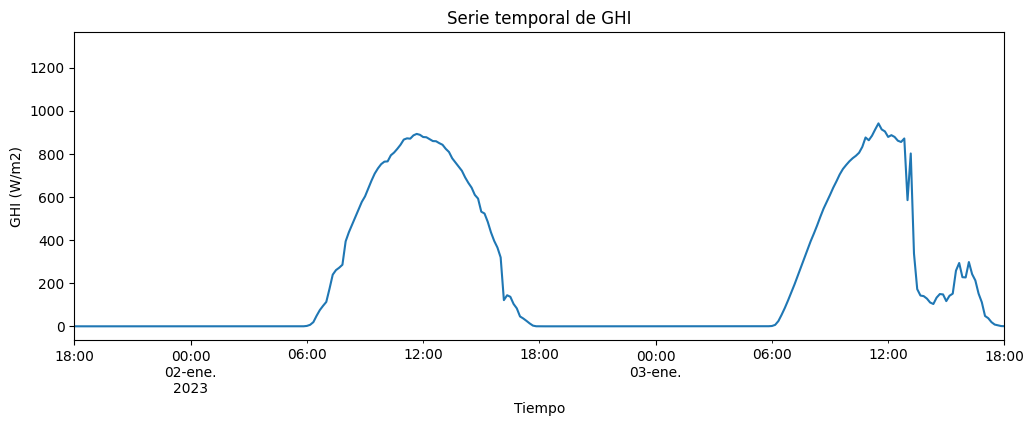

In [29]:
# --- Visualización GHI ---
plt.figure(figsize=(12,4))
df["GHI"].plot()
plt.title("Serie temporal de GHI")
plt.xlabel("Tiempo")
plt.ylabel("GHI (W/m2)")
plt.xlim("2023-01-01 18:00:00+00:00", "2023-01-03 18:00:00+00:00")
plt.show()

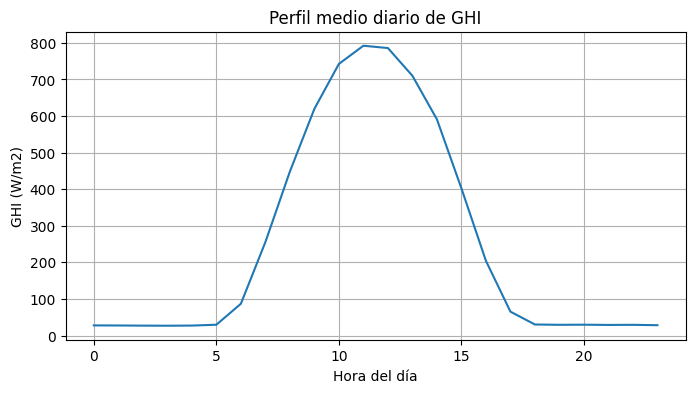

In [26]:
# --- Perfil diario promedio ---
df["hour"] = df.index.hour
daily_profile = df.groupby("hour")["GHI"].mean()
daily_profile.plot(kind="line", figsize=(8,4))
plt.title("Perfil medio diario de GHI")
plt.xlabel("Hora del día")
plt.ylabel("GHI (W/m2)")
plt.grid(True)
plt.show()

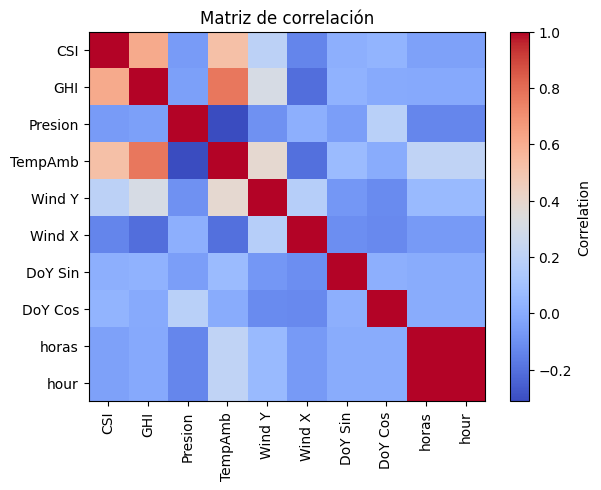

In [27]:
# --- Correlaciones ---
corr = df.corr()
plt.imshow(corr, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Matriz de correlación")
plt.show()